# Data prep

In [26]:
import pandas as pd

df0 = pd.read_csv("data.csv")

## Filter the data to only books that fall under a single genre (of the alpha part of the BISAC)

In [91]:
import re
import ast

df = pd.DataFrame()

# trim BISACs to just the alpha part
df["BISAC"] = (
    df0["BISAC"]
    .apply(ast.literal_eval)
    .apply(lambda x: [re.sub(r"[^a-zA-Z]", "", bisac) for bisac in x])
)
# remove duplicate BISACs
df["BISAC"] = df["BISAC"].apply(lambda x: list(set(x)))
# remove the rows of any BISACs with multiple categories
df = df[df["BISAC"].apply(len) == 1]
df["BISAC"] = df["BISAC"].apply(lambda x: x[0])

## Create a balanced dataset of the top 10 genres, 1000 books each

In [92]:
# find the top 10 most common BISACs
top_10 = df["BISAC"].value_counts().head(10)
# filter the dataset to only include the top 10 BISACs
df = df[df["BISAC"].isin(top_10.index)]
# balance the dataset
df = (
    df.groupby("BISAC")
    .apply(lambda x: x.sample(n=1000))
    .reset_index(drop=True, level=0)
)

/tmp/ipykernel_2184570/4075586292.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1000))


In [99]:
df1 = df0[df0.index.isin(df.index)].copy()
df1.drop(columns=["BISAC"], inplace=True)
df1["BISAC"] = df["BISAC"]
df = df1

## Create train test split


In [114]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["BISAC"])
train.to_csv("train.csv")
test.to_csv("test.csv")

# Vectorizing

## Doc2vec

In [109]:
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


def create_model(df, column_name):
    model_name = f"doc2vec_{column_name}.model"

    model = Doc2Vec(
        vector_size=100,
        window=5,
        alpha=0.025,
        min_alpha=0.00025,
        seed=42,
        max_vocab_size=10000,
        dm=1,
        workers=os.cpu_count(),
        epochs=20,
    )

    tagged_data = [
        TaggedDocument(
            words=word_tokenize(doc.lower()),
            tags=[str(i)],
        )
        for i, doc in enumerate(df[column_name])
    ]
    print("Documents tagged, building")

    model.build_vocab(tagged_data)
    model.train(
        tagged_data,
        total_examples=model.corpus_count,
        epochs=model.epochs,
        report_delay=1,
    )
    model.save(model_name)


create_model(train, "summary")
create_model(train, "text")

Documents tagged, building


In [159]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

summary_model: Doc2Vec = Doc2Vec.load("doc2vec_summary.model")
text_model: Doc2Vec = Doc2Vec.load("doc2vec_text.model")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

models = [summary_model, text_model]
column_names = ["summary", "text"]

datasets = [train, test]
dataset_names = ["train", "test"]

for model, column_name in zip(models, column_names):
    for dataset, dataset_name in zip(datasets, dataset_names):
        df = dataset[column_name].progress_apply(
            lambda x: model.infer_vector(word_tokenize(x.lower()))
        )
        df = df.apply(pd.Series)
        df.to_csv(f"{dataset_name}_word2vec_{column_name}.csv", index=False)

100%|██████████| 2000/2000 [01:21<00:00, 24.66it/s]


## TF-IDF

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

datasets = [train, test]
dataset_names = ["train", "test"]

for column_name in ["summary", "text"]:
    tfidf = TfidfVectorizer(max_features=10000)
    tfidf.fit(train[column_name])

    for dataset, dataset_name in zip(datasets, dataset_names):
        df = tfidf.transform(dataset[column_name])
        df = pd.DataFrame(df.toarray(), columns=tfidf.get_feature_names_out())
        df.to_csv(f"{dataset_name}_tfidf_{column_name}.csv", index=False)

# Clustering

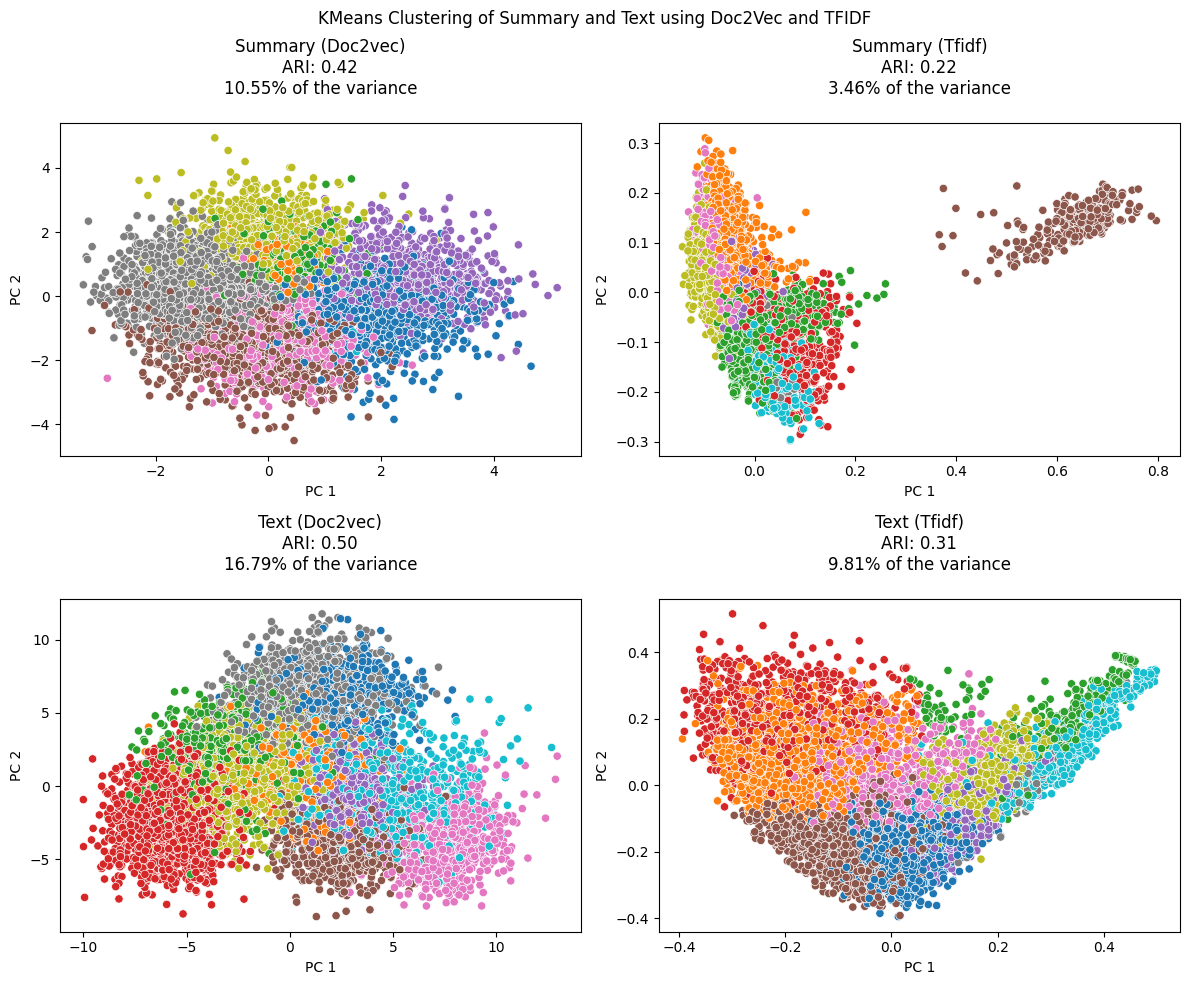

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA


labels = pd.read_csv("data/train.csv")["BISAC"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

fig.suptitle("KMeans Clustering of Summary and Text using Doc2Vec and TFIDF")

for i, column_name in enumerate(["summary", "text"]):
    for j, vectorizer_type in enumerate(["word2vec", "tfidf"]):
        train = pd.read_csv(f"data/train_{vectorizer_type}_{column_name}.csv")

        kmeans = KMeans(n_clusters=10, random_state=42)
        clusters = kmeans.fit_predict(train)

        ari = adjusted_rand_score(labels, clusters)

        pca = PCA(n_components=2, random_state=42)
        train_pca = pca.fit_transform(train)
        explained_variance = pca.explained_variance_ratio_
        percentage_variance = sum(explained_variance[:2]) * 100

        ax = sns.scatterplot(
            data=pd.DataFrame(train_pca),
            x=train_pca[:, 0],
            y=train_pca[:, 1],
            hue=clusters,
            palette="tab10",
            ax=axes[i, j],
            legend=False,
        )

        if vectorizer_type == "word2vec":
            vectorizer_type = "doc2vec"
        ax.set_title(
            f"{column_name.capitalize()} ({vectorizer_type.capitalize()})\nARI: {ari:.2f}\n{percentage_variance:.2f}% of the variance\n"
        )
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")


plt.tight_layout()
plt.savefig("clustering.png")
plt.show()

# Classification

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pandas as pd
import os


with open("classification.txt", "w") as f:
    f.write("")

for column_name in ["summary", "text"]:
    for vectorizer_type in ["word2vec", "tfidf", "tfidf_pca"]:
        train = pd.read_csv(
            f"data/train_{vectorizer_type.split('_')[0]}_{column_name}.csv"
        )
        test = pd.read_csv(
            f"data/test_{vectorizer_type.split('_')[0]}_{column_name}.csv"
        )

        if vectorizer_type == "tfidf_pca":
            pca = PCA(n_components=100, random_state=42)
            train = pca.fit_transform(train)
            test = pca.transform(test)

        param_grid = {"C": [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}

        grid_search = GridSearchCV(
            LogisticRegression(random_state=42, max_iter=1000),
            param_grid,
            cv=5,
            n_jobs=os.cpu_count(),
        )

        train_labels = pd.read_csv("data/train.csv")["BISAC"]
        test_labels = pd.read_csv("data/test.csv")["BISAC"]
        grid_search.fit(train, train_labels)
        print(grid_search.best_params_)
        best_model = grid_search.best_estimator_
        predicted_labels = best_model.predict(test)

        with open("classification.txt", "a") as f:
            f.write(
                f"{column_name.capitalize()} using {vectorizer_type.capitalize()}\n"
            )
            f.write(str(grid_search.best_params_) + "\n")
            f.write(classification_report(test_labels, predicted_labels))
            f.write("\n" + "-" * 80 + "\n\n")

{'C': 0.03}
{'C': 10}
{'C': 10}
{'C': 0.01}
{'C': 10}
{'C': 30}
